In [9]:
# %%writefile em1dtd_inv_test.py
from SimPEG import *
from simpegEM1D import (
    EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, 
    set_mesh_1d, EM1DAnalytics
)
import numpy as np
from simpegEM1D import skytem_HM_2015
wave = skytem_HM_2015()
time = np.logspace(-6, -2, 21)
hz = get_vertical_discretization_time(time, facter_tmax=0.5, factor_tmin=10.)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC

# time_input_currents = np.r_[0., 5.5*1e-4, 5.5*1e-4+1e-5]
# input_currents = np.r_[0., 1., 0.]
time_input_currents = wave.current_times[-7:]
input_currents = wave.currents[-7:]

TDsurvey = EM1DSurveyTD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    topo = np.r_[0., 0., 100.],
    depth = depth,
    rx_type = 'dBzdt',
    wave_type = 'general',
    src_type = 'CircularLoop',
    a = 13.,
    time = time,
    time_input_currents=time_input_currents,
    input_currents=input_currents,
    n_pulse = 2,
    base_frequency = 25.            
)

# TDsurvey = EM1DSurveyTD(
#     rx_location = np.array([0., 0., 100.+30.]),
#     src_location = np.array([0., 0., 100.+30.]),
#     topo = np.r_[0., 0., 100.],
#     depth = depth,
#     rx_type = 'dBzdt',
#     wave_type = 'stepoff',
#     src_type = 'CircularLoop',
#     a = 13.,
#     I = 1.,
#     time = time
# )

sig_half = 1e-2
sig_blk = 1e-1
chi_half = 0.
expmap = Maps.ExpMap(mesh1D)
sig  = np.ones(TDsurvey.n_layer)*sig_half
blk_ind = (0>LocSigZ) & (-30<LocSigZ)
sig[blk_ind] = sig_blk
m_true = np.log(sig)
prob = EM1D(mesh1D, sigmaMap=expmap, verbose=True)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.chi = np.zeros(TDsurvey.n_layer)
d_true = TDsurvey.dpred(m_true)
TDsurvey.dtrue = d_true
std = 0.1
noise = std*abs(TDsurvey.dtrue)*np.random.randn(*TDsurvey.dtrue.shape)
floor = 0.
std = 0.15
TDsurvey.dobs = TDsurvey.dtrue+noise
uncert = abs(TDsurvey.dobs)*std+floor

dmisfit = DataMisfit.l2_DataMisfit(TDsurvey)
dmisfit.W = 1./(abs(TDsurvey.dobs)*std+floor)
m0 = np.log(np.ones_like(sig)*sig_half)
reg = Regularization.Simple(
    mesh1D
)
opt = Optimization.InexactGaussNewton(maxIter = 3)
opt.maxIterLS = 5
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2., coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
inv.run(m0)

>> Use Key 101 (2009) filter for Hankel Transform
>> Compute response
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
>> Compute response
>> Compute J sigma
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.55e+00  2.84e+02  0.00e+00  2.84e+02    3.79e+01      0              
>> Compute response
>> Compute response
>> Compute J sigma
   1  7.73e-01  9.25e+01  8.61e+00  9.92e+01    3.74e+01      1              
>> Compute response
>> Compute response
>> Compute J sigma
   2  3.87e-01  3.01e+01  1.56e+01  3.62e+01    2.91e+01      1              


array([-3.2456278 , -3.04218769, -2.76494185, -2.53276791, -2.43257014,
       -2.39881902, -2.36439263, -2.50379431, -2.9245659 , -3.47561076,
       -3.95574707, -4.26389668, -4.3947426 , -4.39935487, -4.35439024,
       -4.32932513, -4.3540888 , -4.41121382, -4.45548236])

In [10]:
# !python em1dtd_inv_test.py

In [11]:
from simpegEM1D.Waveforms import piecewise_pulse
def step_func(time):
    return EM1DAnalytics.dBzdtAnalCircT(
    TDsurvey.a, time, sig_half
    )
from scipy.interpolate import interp1d

response_analytic = piecewise_pulse(
    step_func, time, 
    TDsurvey.time_input_currents, TDsurvey.input_currents,
    TDsurvey.period, n_pulse=1
)

response_analytic_double = piecewise_pulse(
    step_func, time, 
    TDsurvey.time_input_currents, TDsurvey.input_currents,
    TDsurvey.period, n_pulse=2
)

In [12]:
import properties

In [15]:
from empymod.utils import check_time
import matplotlib.pyplot as plt

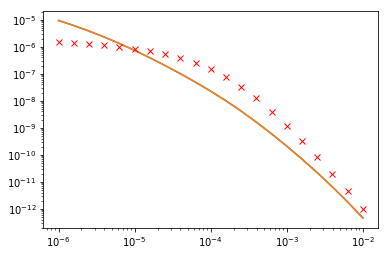

In [16]:
# plt.loglog(time, -response_analytic_test, 'k.-')
plt.loglog(time, -response_analytic)
plt.loglog(time, -response_analytic_double)
plt.loglog(TDsurvey.time, -d_true, 'rx')

In [17]:
from scipy.interpolate import interp1d

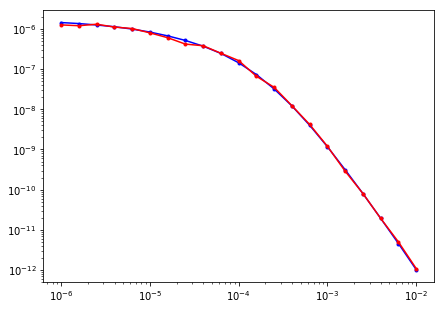

In [19]:
fig, axes = plt.subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -d_true, 'b.-')
axes.plot(TDsurvey.time, -TDsurvey.dobs, 'r.-')
axes.set_xscale('log');
axes.set_yscale('log');

In [23]:
# fig, ax = plt.subplots(1,1, figsize=(5, 8))
# Utils1D.plotLayer(sig, mesh1D)
# Utils1D.plotLayer(expmap*mopt, mesh1D, showlayers=True, **{'color':'r'})

In [24]:
# fig, axes = subplots(1,1, figsize = (7,5))
# axes.plot(TDsurvey.time, -invProb.dpred, 'b-')
# axes.plot(TDsurvey.time, -TDsurvey.dobs, 'bx')
# axes.set_xscale('log');
# axes.set_yscale('log');

In [25]:
# %%time
# dpredall = []
# maxIter = len(xc)
# prob.jacSwitch = False
# for i in range(maxIter):
#     dpredtemp = TDsurvey.dpred(xc[i])
#     dpredall.append(dpredtemp)

In [26]:
# from JSAnimation import IPython_display
# from matplotlib import animation

# fig, ax = subplots(1,2, figsize=(14, 8))
# ax[0].plot(sig, LocSigZ,  'b.-', lw=2)
# ax[0].grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)
# ax[1].grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)

# ax[1].plot(TDsurvey.time, -(TDsurvey.dobs), 'r.-', lw=2)
# ax[0].set_xscale('log')
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
# ax[0].set_xlim(1e-6, 1e-2)


# frame1, = ax[0].plot([], [],  'r.-', lw=2)
# frame2, = ax[1].plot([], [],  'b.-' , lw=2)

# def animate(i_id):
    
#     frame1.set_data(expmap*xc[i_id], LocSigZ)
#     frame2.set_data(TDsurvey.time, -(dpredall[i_id]))
    
#     ax[0].legend(('True', 'Pred'), loc=1, fontsize = 14)
#     ax[1].legend(('True', 'Pred'), loc=1, fontsize = 14)
    
#     ax[0].set_title('$\sigma$ model, Iter = ' + str(i_id+1), fontsize = 16)
#     ax[1].set_title('Pred and Obs data, Iter = ' + str(i_id+1), fontsize = 16)
#     return frame1, frame2

# animation.FuncAnimation(fig, animate, frames=maxIter, interval=40, blit=True)